In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
import keras

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Self Projects/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [7]:
len(dataset)

141

In [8]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

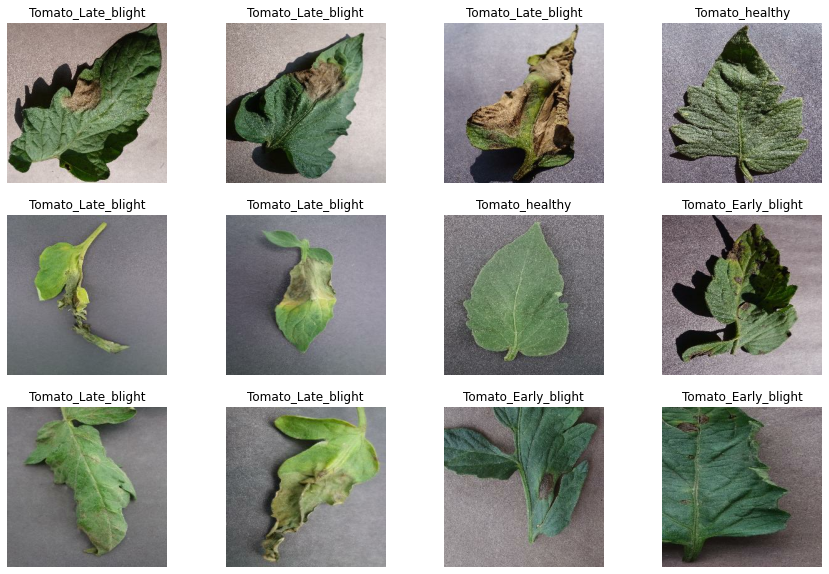

In [9]:
plt.figure(figsize=(15,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
train_size=0.8
len(dataset)*train_size

112.80000000000001

In [11]:
train_ds=dataset.take(112)
len(train_ds)

112

In [12]:
test_ds=dataset.skip(112)
len(test_ds)

29

In [13]:
val_size=0.1
len(dataset)*val_size

14.100000000000001

In [14]:
val_ds=test_ds.take(14)
len(val_ds)

14

In [15]:
test_ds=test_ds.skip(14)
len(test_ds)

15

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [18]:
len(val_ds)

14

In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [25]:
basemodel=keras.applications.vgg16.VGG16(weights='imagenet',input_shape=input_shape,include_top=False)

58900480/58889256 [==============================] - 2s 0us/step


In [26]:
basemodel.trainable = False
inputs = keras.Input(shape=(256, 256, 3))
x = basemodel(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

# activation =  tf.keras.activations.sigmoid #None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(3,
                             kernel_initializer=initializer,
                             activation='softmax')(x) 
model = keras.Model(inputs, outputs)




#Store the fully connected layers
fc1 =model.layers[-3]
fc2 = model.layers[-2]
predictions = model.layers[-1]

# Create the dropout layers
dropout1 = keras.layers.Dropout(0.50)
dropout2 = keras.layers.Dropout(0.10)

# Reconnect the layers
x = dropout1(fc1.output)
x = fc2(x)
x = dropout2(x)
predictors = predictions(x)

# Create a new model
model2 = keras.Model(basemodel.input, predictors)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                                 
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 [==============================] - 420s 500ms/step - loss: 1.3546 - accuracy: 0.6005 - val_loss: 0.4895 - val_accuracy: 0.8103
Epoch 2/50
112/112 [==============================] - 46s 410ms/step - loss: 0.4470 - accuracy: 0.8371 - val_loss: 0.3398 - val_accuracy: 0.8728
Epoch 3/50
112/112 [==============================] - 46s 409ms/step - loss: 0.3080 - accuracy: 0.8858 - val_loss: 0.2836 - val_accuracy: 0.8817
Epoch 4/50
112/112 [==============================] - 46s 411ms/step - loss: 0.2577 - accuracy: 0.9031 - val_loss: 0.2475 - val_accuracy: 0.9040
Epoch 5/50
112/112 [==============================] - 47s 421ms/step - loss: 0.2233 - accuracy: 0.9183 - val_loss: 0.2060 - val_accuracy: 0.9107
Epoch 6/50
112/112 [==============================] - 47s 417ms/step - loss: 0.2051 - accuracy: 0.9219 - val_loss: 0.1842 - val_accuracy: 0.9196
Epoch 7/50
112/112 [==============================] - 46s 410ms/step - loss: 0.1873 - accuracy: 0.9320 - val_loss: 0.1764 - val_a

In [32]:
scores=model.evaluate(test_ds)

15/15 [==============================] - 11s 192ms/step - loss: 0.1417 - accuracy: 0.9417


In [33]:
scores

[0.14174629747867584, 0.9416666626930237]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

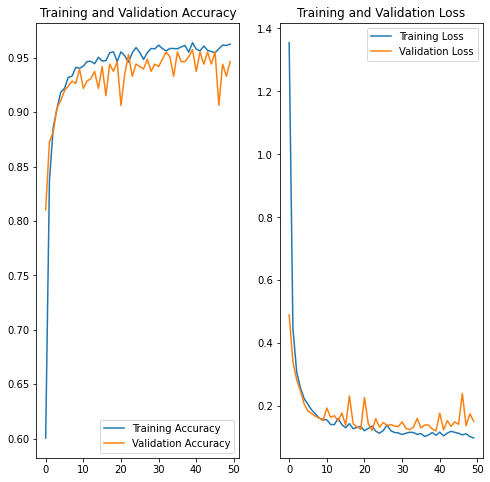

In [37]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_healthy
predicted label: Tomato_healthy


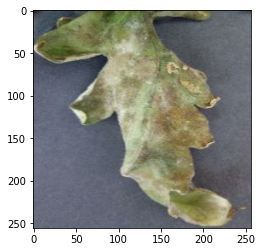

In [38]:
import numpy as np


for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = (labels_batch[0]).numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    

In [39]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

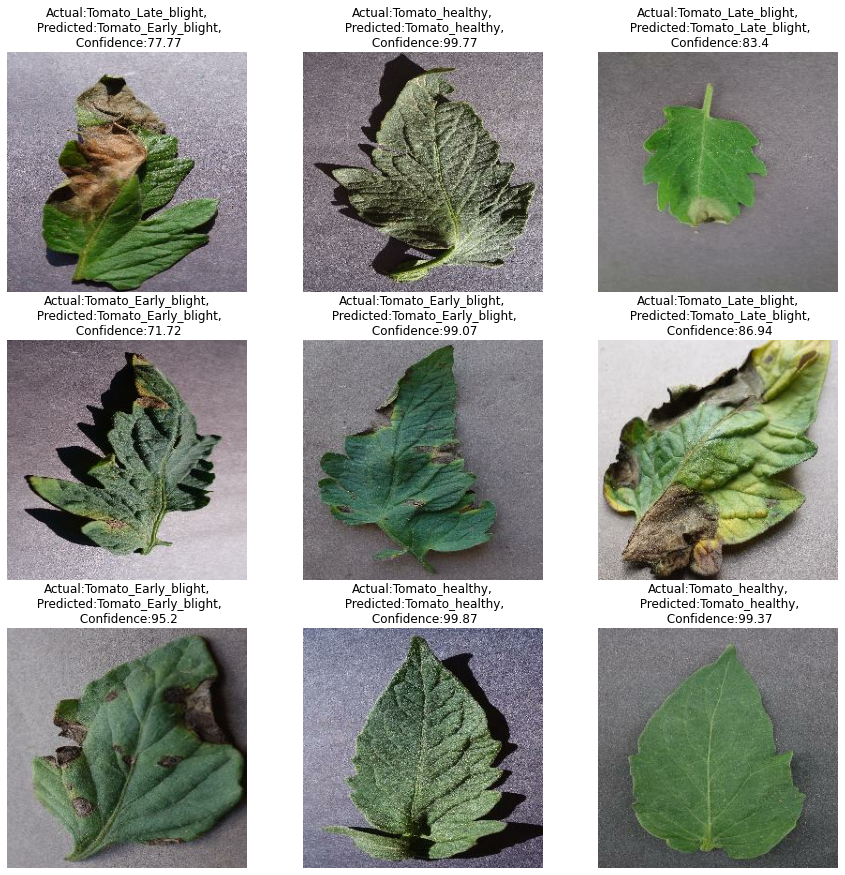

In [40]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}")
        plt.axis("off")

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 [==============================] - 334s 351ms/step - loss: 0.7973 - accuracy: 0.6372 - val_loss: 0.5505 - val_accuracy: 0.8103
Epoch 2/50
112/112 [==============================] - 30s 271ms/step - loss: 0.3843 - accuracy: 0.8387 - val_loss: 0.3835 - val_accuracy: 0.8326
Epoch 3/50
112/112 [==============================] - 30s 271ms/step - loss: 0.3908 - accuracy: 0.8460 - val_loss: 0.6319 - val_accuracy: 0.7902
Epoch 4/50
112/112 [==============================] - 30s 271ms/step - loss: 0.3245 - accuracy: 0.8715 - val_loss: 0.4749 - val_accuracy: 0.8237
Epoch 5/50
112/112 [==============================] - 31s 279ms/step - loss: 0.3644 - accuracy: 0.8480 - val_loss: 0.3891 - val_accuracy: 0.8348
Epoch 6/50
112/112 [==============================] - 30s 271ms/step - loss: 0.3070 - accuracy: 0.8718 - val_loss: 0.7159 - val_accuracy: 0.7500
Epoch 7/50
112/112 [==============================] - 30s 270ms/step - loss: 0.2633 - accuracy: 0.8905 - val_loss: 0.6822 - val_a

In [27]:
scores=model.evaluate(test_ds)

15/15 [==============================] - 9s 32ms/step - loss: 0.2749 - accuracy: 0.9083


In [28]:
scores

[0.2748623490333557, 0.9083333611488342]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

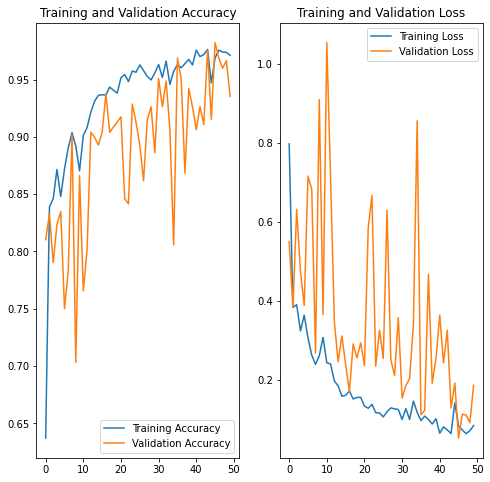

In [31]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Late_blight
predicted label: Tomato_Late_blight


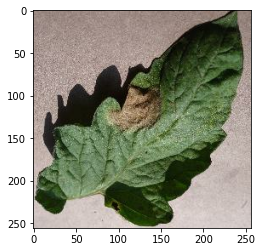

In [32]:
import numpy as np


for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = (labels_batch[0]).numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    

In [33]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

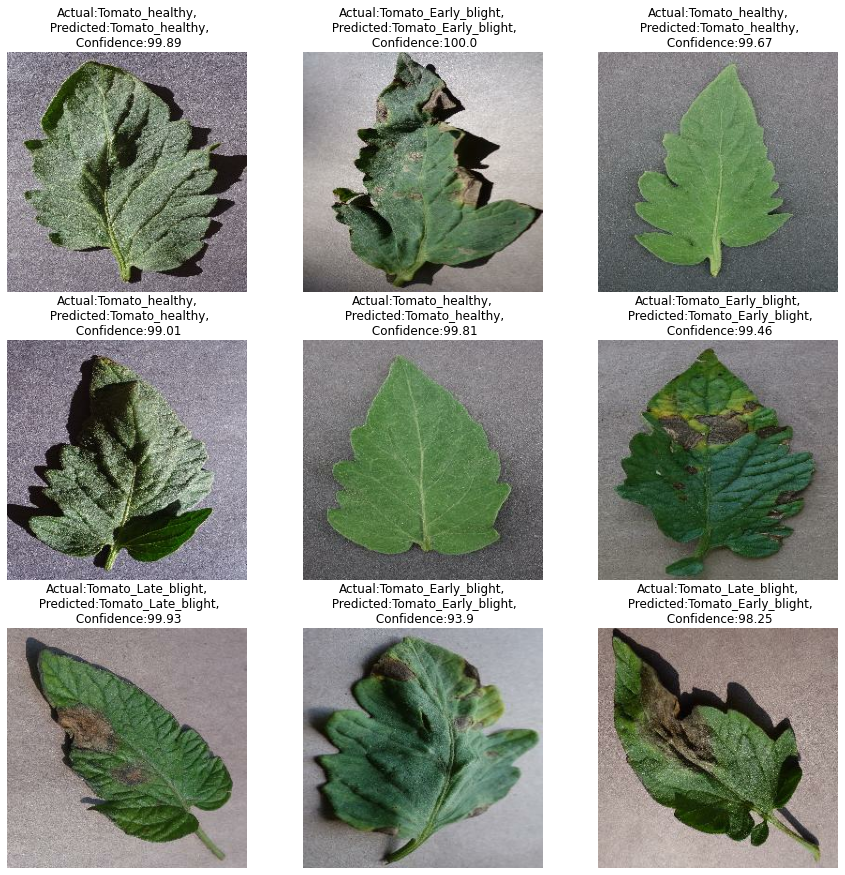

In [34]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}")
        plt.axis("off")

In [37]:
# import os
# os.listdir("C:\Machine_learning_lab\deeplearn\Plant_village")

In [36]:
model_version=2
model.save(f"C:\Machine_learning_lab\deeplearn\Plant_village/{model_version}")